# Intro to Web-Based Visualization

While `matplotlib` is exceptionally feature rich and capable of producing high quality graphics (even if not always easy to do so), it leaves a lot to be desired when users want some quality-of-life features that in 2021 are commonplace. Being able to hover over data for tooltips, modify colors, and otherwise interact with visualizations are much better suited for the web. We are first going to take a quick look over a few of the technologies available to us.

## hvPlot

`hvPlot` provide an extra set of features to `pandas` for plotting via `bokeh` instead of `matplotlib`. The fundamental difference between `matplotlib` and `bokeh` is that while `matplotlib` utilizes a graphics renderer, `bokeh` instead uses your web-browser to render its graphics using HTML, CSS, and JavaScript. This gives us some pretty clear benefits up front. We will look at `bokeh` in detail later but first let's see how it works.

If you haven't done so already, go ahead and install hvplot.

```bash
pip install hvplot
```

We will first make some dummy data just to get a feel for things.

<Axes: >

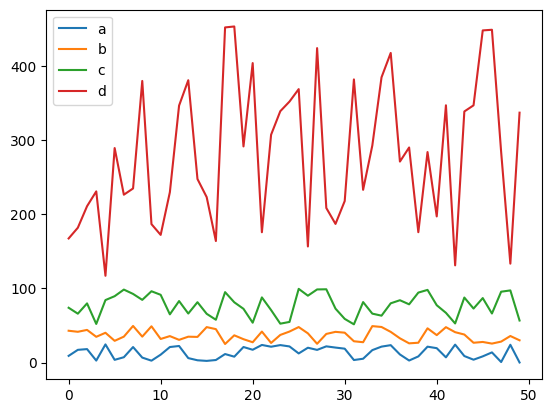

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

df = pd.DataFrame({
    'a': np.random.uniform(0,25,50),    # create random column named "a"
    'b': np.random.uniform(25,50,50),   # create random column named "b"
    'c': np.random.uniform(50,100,50),  # create random column named "c"
    'd': np.random.uniform(100,500,50), # create random column named "d"
})

df.plot() # create a default plot showing each column

The biggest issue here is the static nature of the image. The legend was placed in a suboptimal position and the canvas by default is quite small. These are things that we can fix, but we then need to tweak and re-run, and even then we still cannot interact with the plot itself.

We have seen `%matplotlib widget` that allows some interactivity, but the functionality is quite clunky. We get the size fixed, but the interactivity is minimal and does not have the best response time.

<Axes: >

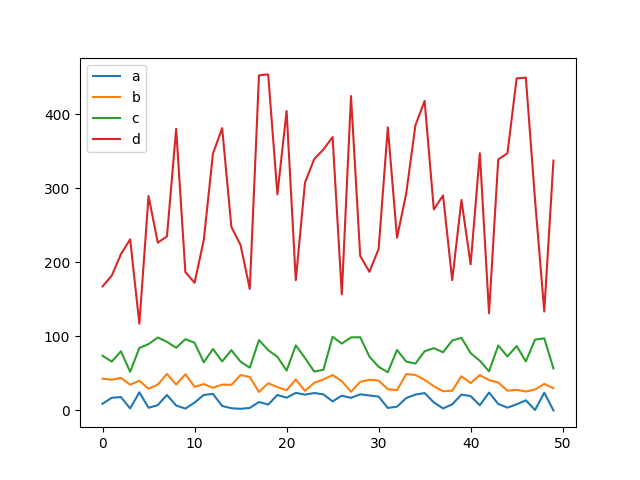

In [2]:
%matplotlib widget
# Recreate the same plot above but with web-based rendering for matplotlib
df.plot()

This is where `hvPlot` comes into play. All we need to so is import it and then call its plotting API over the default one:

In [3]:
# Import hvplot's pandas API
import hvplot.pandas

# Create a default plot showing each column using hvPlot
df.hvplot()

:NdOverlay   [Variable]
   :Curve   [index]   (value)

This is much better! By default our legend was placed *outside* of the plot so as to not cover any data. We also have by default additional ticks on our axes, and like `%matplotlib widget` we have a toolbar to toggle some of the interactive tools and features, except we also have a scroll-zoom as well as a box-zoom. All of these tools also work far more responively than the matplotlib interactions. And most notably though we by deafault have tooltips when hovering over our data! Just mouse over one of the lines in the plot and a tooltip will show information about that data point. We can also *disable* components of our graph by clicking on their entry in the legend!

Without covering anything else for the rest of this notebook it is clear that using `hvPlot` over the standard plotting is superior.

We can do everything we could do with the normal plotting interface:

* plot specific columns against other columns
* use a column for coloring
* use a column for size

In [4]:
# Scatter a vs b, coloring by c and sizing by d
df.hvplot.scatter(x="a", y="b", c="c", s="d")

:Scatter   [a]   (b,c,d)

Some other things we can do that required excessive code or hackish workarounds are freely available via `hvPlot`:

* grouping
* composition

We can add a new column that we can use to categorize the data. Then it is as simple as providing that column as `by` to tell `hvPlot` by what column to group the data.

In [5]:
# Randomly assign a category to each row by adding a column of random values
df["cat"] = np.random.choice(["good", "bad", "ugly"], size=50)

# Scatter a vs b, grouping by the new cat column
df.hvplot.scatter(x="a", y="b", by="cat")

:NdOverlay   [cat]
   :Scatter   [a]   (b)

We can very conveniently compose plots together using simple operations. Using `matplotlib` we would need to create and reuse axis objects which can be extremely cumbersome. Below we look at how we can compose groups of plots and stacked plots.

In [6]:
# Compose two plots by adding them - this creates a layout of plots side-by-side
df.hvplot.line() + df.hvplot.scatter()

:Layout
   .NdOverlay.I  :NdOverlay   [Variable]
      :Curve   [index]   (value)
   .NdOverlay.II :NdOverlay   [Variable]
      :Scatter   [index]   (value)

In [7]:
# Compose two plots by multiplying them - this creates a stacked set of plots
df.hvplot.line() * df.hvplot.scatter()

:Overlay
   .NdOverlay.I  :NdOverlay   [Variable]
      :Curve   [index]   (value)
   .NdOverlay.II :NdOverlay   [Variable]
      :Scatter   [index]   (value)

We also have access to some entirely new ways to combine our data and visualizations beyond what using `Jupyter` provides us. Note that the conventional order of operations holds.

In [8]:
# Compose two plots by multiplying them and then compose a layout showing the
# table itself
df.hvplot.line() * df.hvplot.scatter() + df.hvplot.table()

:Layout
   .Overlay.I :Overlay
      .NdOverlay.I  :NdOverlay   [Variable]
         :Curve   [index]   (value)
      .NdOverlay.II :NdOverlay   [Variable]
         :Scatter   [index]   (value)
   .Table.I   :Table   [a,b,c,d,cat]

## Panel

We can also introduce graphical components, or widgets, into our visualizations to provide custom features. For this we will use a library called `panel`. This library has direct integration with most of the primary data analysis and visualization libraries, and works directly with `hvPlot`. We use widgets to map dyanmic values to some function that operates on and visualizes our data. Not only does this allow us to explore our data space much easier, but seeing how our analysis tranforms is another key aspect of understanding our data.

If you haven't installed panel yet, you can install it with the following command.

```bash
pip install panel
```

Note that you might also need to install a few supporting libraries.

```bash
pip install pyviz-comms
pip install jupyter_bokeh
```

You will need `jupyter_bokeh` if using `panel` in VSCode.

We can start off simple with a function that slices our data based on some threshold and then visualizes it.

In [9]:
import panel as pn

# Create an integer slider with the label "d threshold", an initial value, and
# range (from start to stop)
threshold = pn.widgets.IntSlider(
    name="d threshold", value=500, start=0, end=500
)


# Create a function to slice our data and compose a layout
def slicer(threshold):
    sliced = df[df.d < threshold]  # Slice our data using the threshold for d
    composed_plot = (
        sliced.hvplot.line() * sliced.hvplot.scatter() + sliced.hvplot.table()
    )
    return composed_plot


# Use panel to setup an interaction between our function and our widget
pn.interact(slicer, threshold=threshold)

BokehModel(combine_events=True, render_bundle={'docs_json': {'384a238d-8407-4227-a0db-c566fa23ca55': {'version…

We can anchor the limits of the axes to keep a consistent frame around the data - we do this by applying x-limits and y-limits to the composed plots.

In [10]:
import panel as pn

# Create an integer slider with the label "d threshold", an initial value,
# and a range from start to stop
threshold = pn.widgets.IntSlider(
    name="d threshold", value=500, start=0, end=500
)


# Create a function to slice our data and compose a layout
def slicer(threshold):
    sliced = df[df.d < threshold]  # Slice our data using the threshold for d
    # Compose the plot and then set its xlim and ylim options
    _viz = (sliced.hvplot.line() * sliced.hvplot.scatter()).opts(
        xlim=(0, 50), ylim=(0, 500)
    )
    # Compose the plot with the table and return the composition
    return _viz + sliced.hvplot.table()


# Use panel to setup an interaction between our function and our widget
pn.interact(slicer, threshold=threshold)

BokehModel(combine_events=True, render_bundle={'docs_json': {'50771623-d2e2-4835-a0ae-4eb5a89629ee': {'version…

## So Many Features

The combination of `hvPlot` and `panel` opens the doors to an incredible number of opportunities for visualizing and interacting with your data. While some of these require a small amount of work or setup to use, we have the following visualizations available right out of the box from `hvPlot` (not limited to):

* `area` - line plots with shaded regions between lines and axes
* `bar` - standard bar graph
* `barh` - standard bar graph oriented horizontally
* `bivariate` - 2d-distribution/density contour plot
* `box` - standard box-and-whisker plot
* `errorbars` - used to create box-and-whisker-like error spreads on data
* `heatmap` - standard heatmap
* `hexbin` - 2-dimensional histogram-like plot using hexagons to represent bins
* `hist` - standard histogram
* `kde` - kernel density estimate - similar to a histogram but uses a smoothed function instead of discrete bins
* `labels` - standard scatter using labels instead of points
* `line` - standard line plot
* `ohlc` - open-high-low-close candlesticks used for visualizing trading/financial data
* `scatter` - standard scatter plot
* `step` - line plot but with horizontal steps between points intead of linear fits
* `table` - special display feature for tables
* `violin` - similiar to a box-and-whisker plot, but shows distibution of data

We even have a number of visualizations from `pandas` or `seaborn` made available through `hvPlot`, thoough these have a slightly different interface than the plots above:

* `scatter_matrix` - provide a combinatorial comparison between all variables along with a separate analysis across the diagonal
* `parallel_coordinates`
* `andrews_curves`
* `lag_plot`

The `panel` library provides us with the following widgets (but not limited to):

* `IntSlider` - Select an integer value within a set bounds using a slider.
* `IntRangeSlider` - Select an integer range using a slider with two handles.
* `FloatSlider` - Select a float value within a set bounds using a slider.
* `RangeSlider` - Select a floating-point range using a slider with two handles.
* `DateSlider` - Select a date value within a set bounds using a slider.
* `DateRangeSlider` - Select a date range using a slider with two handles.
* `Checkbox` - Toggle a single condition between True/False states by ticking a checkbox.
* `Toggle` - Toggle a single condition between True/False states by clicking a button.
* `TextInput` - Enter any string using a text input box.
* `ColorPicker` - Select a color using the browser’s color-picking utilities.
* `FileInput` - Upload a file from the frontend, making the file data and MIME type available in Python.
* `Button` - Allows triggering events when the button is clicked. Unlike other widgets, it does not have a value parameter.
* `DataFrame` - A widget that allows displaying and editing a Pandas DataFrame.

As we can see there are in fact a tremendous number of features between both libraries, and together we can build comprehensive sets of visualizations much easier than we could with tools like `matplotlib` and `seaborn`. This does not mean that they are useless - the graphical and feature customization of `matplotlib` make it the number one choice for when you need to visual a piece of data and tune it for high quality. 